In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('SpecialtyCare.csv')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,1,2,5,7,15,23,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,person_enc_id,person_id,enc_id,contact_date,appt_time,iso_week_num,weekend_yn,appt_length,appt_made_date,apptstatus,...,specialty_grouping,combined_status,visit_type_id,visit_type_name,tele_clinic_visit,encounter_type,age_at_enc_years,state,patclass,insurance_type
0,1,24889,1,8/24/2019 0:00,8/24/2019 9:00,34,Y,30,8/22/2014 0:00,NaN,...,Specialty Care,No Show/Cancelled,535,AFTER HOURS,Clinic,Appointment,9,New Mexico,Outpatient,Private
1,1,129824,2,2/4/2018 0:00,2/4/2018 10:00,5,Y,60,1/6/2016 0:00,NaN,...,Specialty Care,No Show/Cancelled,1371,HOPE CLINIC FOLLOW UP,Clinic,Appointment,22,Colorado,Outpatient,Private
2,1,33659,3,1/30/2018 0:00,1/30/2018 8:30,5,N,240,11/22/2016 0:00,NaN,...,Specialty Care,No Show/Cancelled,424,SPINAL DEFECTS FU,Clinic,Appointment,13,Colorado,Outpatient,Medicaid
3,1,4228,4,1/9/2018 0:00,1/9/2018 8:30,2,N,240,12/9/2016 0:00,NaN,...,Specialty Care,No Show/Cancelled,424,SPINAL DEFECTS FU,Clinic,Appointment,6,Colorado,Outpatient,Medicaid
4,1,132398,5,1/5/2018 0:00,1/5/2018 13:00,1,N,180,10/24/2017 0:00,NaN,...,Specialty Care,No Show/Cancelled,278,MUSCLE FU,Clinic,Appointment,13,Colorado,Outpatient,Private


## Data Prep

In [ ]:
df = df.drop(['encounter_type','patclass','appt_length','appt_cancel_date','iso_week_num','appt_conf_inst','visit_type_name','department_name','provider_type','person_enc_id','person_id','enc_id','apptstatus','cancel_reason','checkin_time','checkout_time','department_id','prov_primary_department','specialty_grouping','visit_type_id'], axis = 1)
df = df.drop(df.index[549095])

In [ ]:
df['weekend_yn'] = pd.Series(np.where(df['weekend_yn'] == 'Y', 1, 0),
          df.index)

df['cancelled'] = pd.Series(np.where(df['combined_status'] == 'Completed', 1, 0),
          df.index)
df['confirmed'] = pd.Series(np.where(df['combined_status'] != 'Completed', 1, 0),
          df.index)

In [ ]:
df['appt_time'] = pd.to_datetime(df['appt_time'], infer_datetime_format=True)
df['contact_date'] = pd.to_datetime(df['contact_date'], infer_datetime_format=True)
df['appt_made_date'] = pd.to_datetime(df['appt_made_date'], infer_datetime_format=True)

df["age_at_enc_years"] = df["age_at_enc_years"].astype('int')

df["specialty_cat"] = df["specialty"].astype('category')

In [ ]:
df['one'] = 1

In [ ]:
dfcancelled = df[df['cancelled'] == 1]
dfconfirmed = df[df['confirmed'] == 1]

dfpre = df[df['appt_time'] < '2020-02-15 00:00:00']
dfcovid = df[df['appt_time'] >= '2020-02-15 00:00:00']

dfpre = dfpre.sort_values('contact_date')
dfcovid = dfcovid.sort_values('contact_date')

precancelled = dfpre[dfpre['cancelled'] == 1]
preconfirmed = dfpre[dfpre['confirmed'] == 1]
covidcancelled = dfcovid[dfcovid['cancelled'] == 1]
covidconfirmed = dfcovid[dfcovid['confirmed'] == 1]

In [ ]:
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
for col in df.columns: 
    print(col)

contact_date
appt_time
weekend_yn
appt_made_date
specialty
location
combined_status
tele_clinic_visit
age_at_enc_years
state
insurance_type
cancelled
confirmed
specialty_cat
one


In [ ]:
precd = dfpre
covidcd = dfcovid

cols = ['appt_time', 'weekend_yn', 'appt_made_date', 'combined_status', 'specialty', 'location',  'age_at_enc_years', 'state',  'cancelled', 'confirmed',  'specialty_cat',  'tele_clinic_visit', 'insurance_type']
precd.drop(cols, axis=1, inplace=True)
covidcd.drop(cols, axis=1, inplace=True)

precd = precd.groupby('contact_date')['one'].sum().reset_index()
covidcd = covidcd.groupby('contact_date')['one'].sum().reset_index()

precd = precd.set_index('contact_date')
covidcd = covidcd.set_index('contact_date')

## Pre Covid Time Between

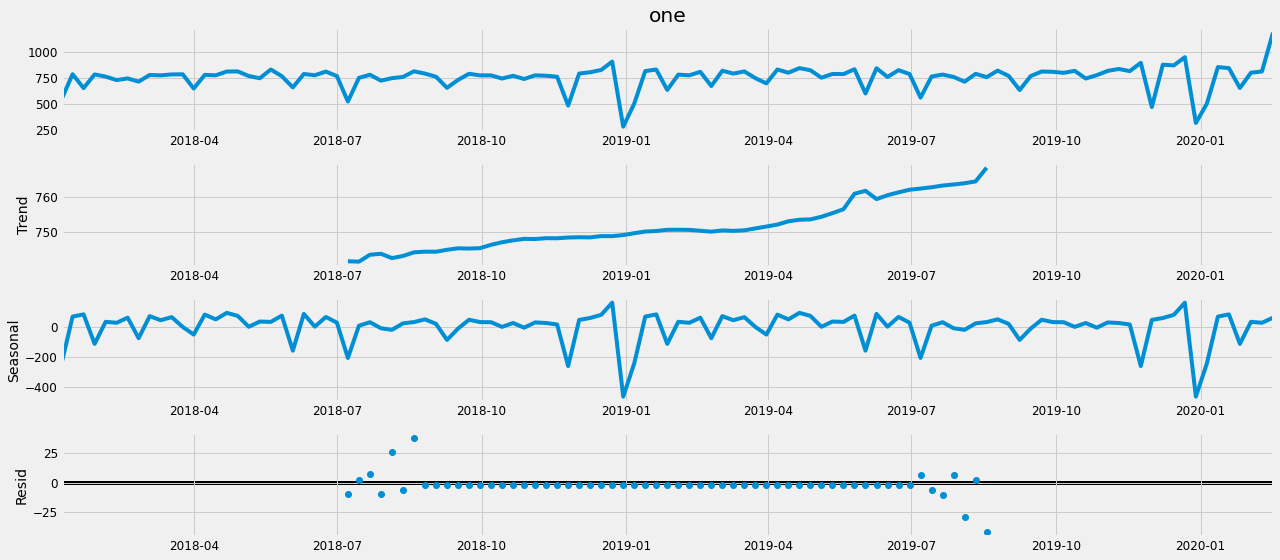

In [ ]:
y = precd['one'].resample('W').mean()

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1775.1139115999333
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1488.8777462313133
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1250.1577113971396
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1082.2534127802849
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1264.2159356744323
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1229.5386522034069
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1107.4588668561864
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1084.0020877249417
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1647.9881326492236
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1405.675301566699
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1239.7325865636499
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1072.6674295949192


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1267.0717386025149


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1220.1101839601351
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1109.4351657259747
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1074.4135104050056
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1405.1726830897453
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1260.4116900275394
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1297.000289155692
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1123.892624168006
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1272.9873738994165
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1262.3957103351102
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1150.3449826410165
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1125.816817613077
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1332.1447271571435
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1196.1863833196253
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1232.273581122514
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1062.4638978829703
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1219.3361403523493
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1197.9860968209955
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1101.5682538703

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1220.6078573810867
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1094.1513047239387
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1074.5554130706685
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1392.2699490189143
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1250.4260818222879
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1286.4680136497045
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1115.0310920454344
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1250.6069328677606
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1252.400267194927
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1129.19531781581
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1117.0307588516466
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1334.1139493845749
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1198.1394989655419
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1233.7633531337501
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1064.4379222184987
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1209.967695289773
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1199.9430628779382
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1090.6600481665

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0181      0.071      0.254      0.800      -0.122       0.158
ma.L1         -1.0000      0.094    -10.678      0.000      -1.184      -0.816
ma.S.L12      -0.7068      0.153     -4.616      0.000      -1.007      -0.407
sigma2      1.564e+04   5.99e-06   2.61e+09      0.000    1.56e+04    1.56e+04


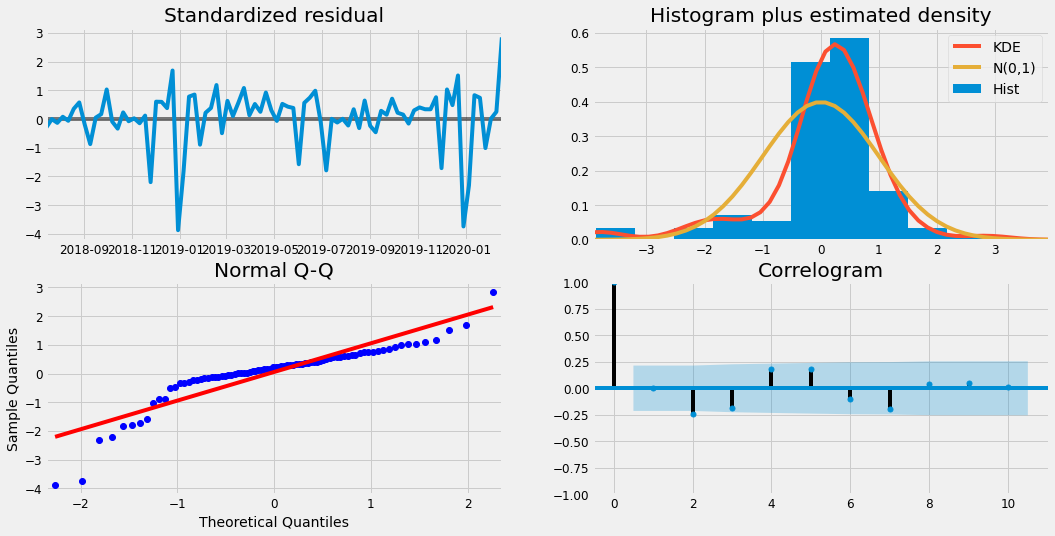

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

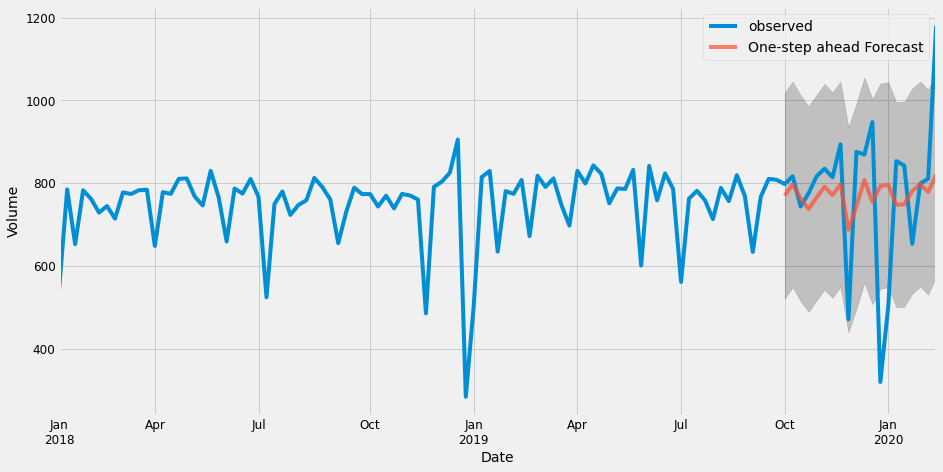

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-10-06'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2018-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

In [ ]:
pred.predicted_mean.mean()

772.5581431758255

In [ ]:
pred.conf_int().mean()

lower one     524.540452
upper one    1020.575834
dtype: float64

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-10-06':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 29938.29
The Root Mean Squared Error of our forecasts is 173.03


In [ ]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y_truth, y_forecasted)
mse = metrics.mean_squared_error(y_truth, y_forecasted)
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Absolute Error of our forecasts is 121.3
The Mean Squared Error of our forecasts is 29938.29
The Root Mean Squared Error of our forecasts is 173.03


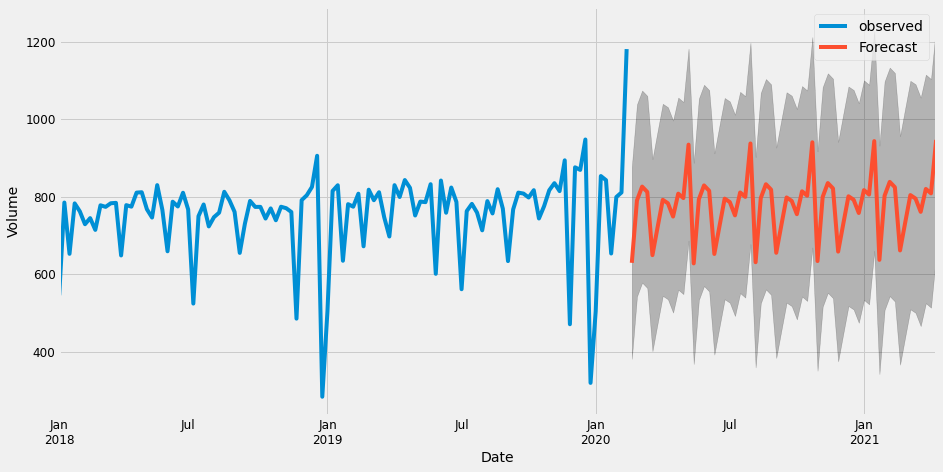

In [ ]:
pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

## Covid Time Between

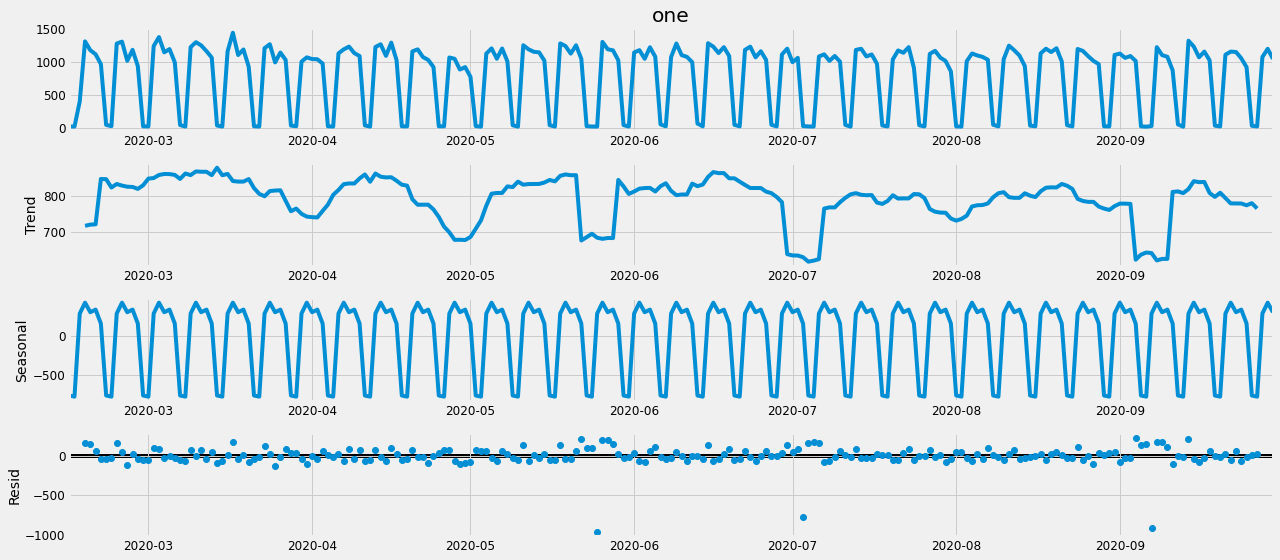

In [ ]:
z = covidcd['one'].resample('D').mean()

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(z, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(z,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3770.738153894617
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3509.3297437590645
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3523.138745971064
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3158.1888951416345
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3493.8190428045646
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3353.055520737184
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3295.4826316376384
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3138.1112418174685
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3561.628127820778
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3354.8978757211894
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3420.296194203155
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3063.605823402056
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3374.3896030160076
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3254.668186669265
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3187.888329766947
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3043.64429407316
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3530.5932454353087
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3260.4201197697457
AR

In [ ]:
mod = sm.tsa.statespace.SARIMAX(z,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1229      0.131      0.935      0.350      -0.135       0.380
ma.L1          0.5768      0.089      6.493      0.000       0.403       0.751
ar.S.L12      -0.3554      0.077     -4.621      0.000      -0.506      -0.205
ma.S.L12      -1.0003     10.025     -0.100      0.921     -20.649      18.649
sigma2      1.585e+05    1.6e+06      0.099      0.921   -2.97e+06    3.28e+06


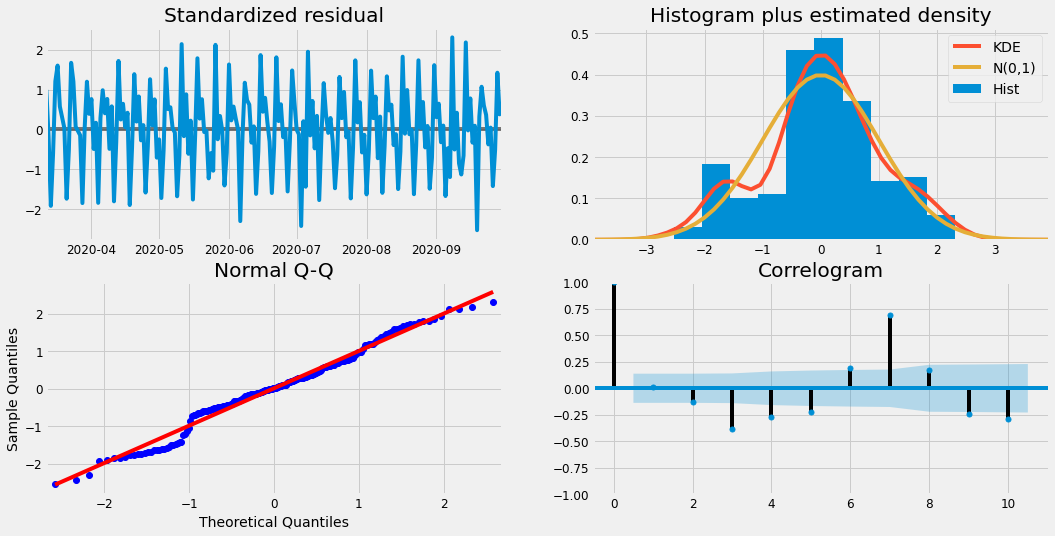

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

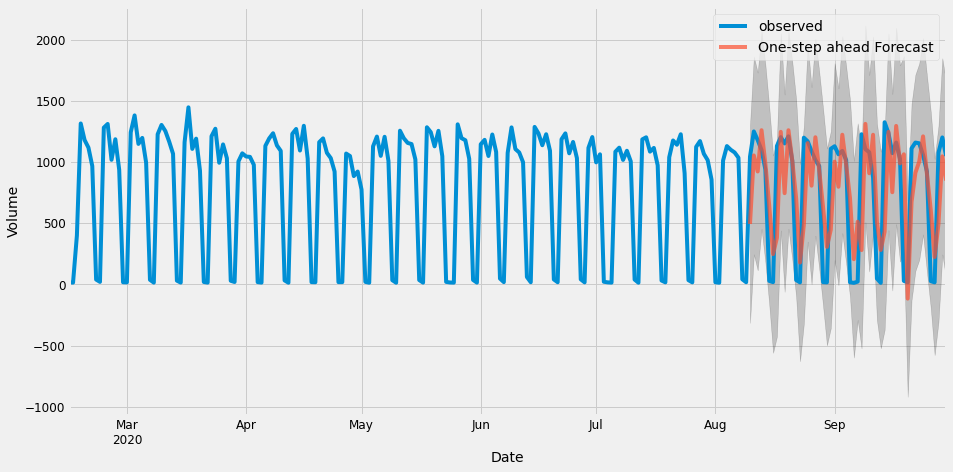

In [ ]:
predz = results.get_prediction(start=pd.to_datetime('2020-08-10'), dynamic=False)
pred_ci = predz.conf_int()
ax = z['2020-02':].plot(label='observed')
predz.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

In [ ]:
predz.predicted_mean.mean()

781.8514150399649

In [ ]:
predz.conf_int().mean()

lower one     -22.771457
upper one    1586.474287
dtype: float64

In [ ]:
z_forecasted = predz.predicted_mean
z_truth = z['2020-08-10':]
mse = ((z_forecasted - z_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 171587.12
The Root Mean Squared Error of our forecasts is 414.23


In [ ]:
mae = metrics.mean_absolute_error(z_truth, z_forecasted)
mse = metrics.mean_squared_error(z_truth, z_forecasted)
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Absolute Error of our forecasts is 318.77
The Mean Squared Error of our forecasts is 171587.12
The Root Mean Squared Error of our forecasts is 414.23


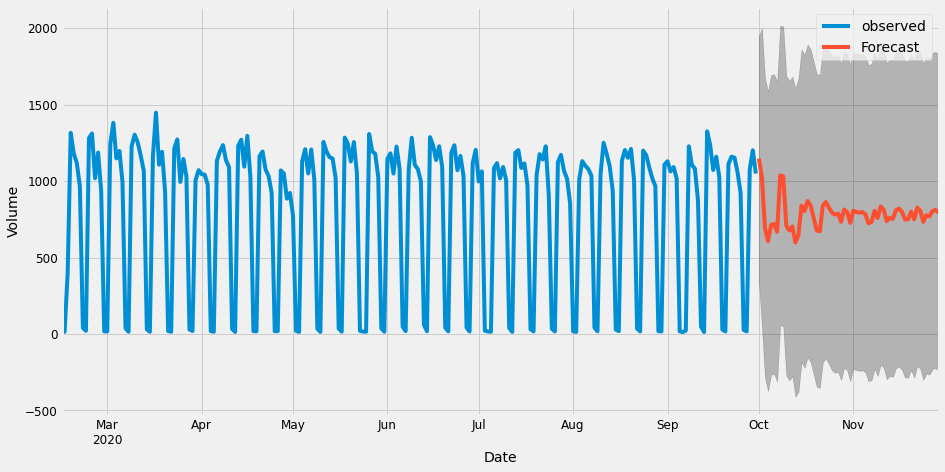

In [ ]:
pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = z.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

## Cancelled vs. Confirmed

In [ ]:
precan = precancelled
precon = preconfirmed
covidcan = covidcancelled
covidcon = covidconfirmed

cols = ['appt_time', 'weekend_yn', 'appt_made_date', 'combined_status', 'specialty', 'location',  'age_at_enc_years', 'state',  'cancelled', 'confirmed',  'specialty_cat',  'tele_clinic_visit', 'insurance_type']
precan.drop(cols, axis=1, inplace=True)
precon.drop(cols, axis=1, inplace=True)
covidcan.drop(cols, axis=1, inplace=True)
covidcon.drop(cols, axis=1, inplace=True)

precan = precan.groupby('contact_date')['one'].sum().reset_index()
precon = precon.groupby('contact_date')['one'].sum().reset_index()
covidcan = covidcan.groupby('contact_date')['one'].sum().reset_index()
covidcon = covidcon.groupby('contact_date')['one'].sum().reset_index()

precan = precan.set_index('contact_date')
precon = precon.set_index('contact_date')
covidcan = covidcan.set_index('contact_date')
covidcon = covidcon.set_index('contact_date')

y_can = precan['one'].resample('W').mean()
y_con = precon['one'].resample('W').mean()
z_can = covidcan['one'].resample('D').mean()
z_con = covidcon['one'].resample('D').mean()

precan = pd.DataFrame({'contact_date':y_can.index, 'one':y_can.values})
precon = pd.DataFrame({'contact_date':y_con.index, 'one':y_con.values})
covidcan = pd.DataFrame({'contact_date':z_can.index, 'one':z_can.values})
covidcon = pd.DataFrame({'contact_date':z_con.index, 'one':z_con.values})

pre = precan.merge(precon, how='inner', on='contact_date')
pre.dropna(inplace=True)
pre.rename(columns={'one_x': 'cancelled_vol', 'one_y': 'confirmed_vol'}, inplace=True)

covid = covidcan.merge(covidcon, how='inner', on='contact_date')
covid.dropna(inplace=True)
covid.rename(columns={'one_x': 'cancelled_vol', 'one_y': 'confirmed_vol'}, inplace=True)


### Pre CvC

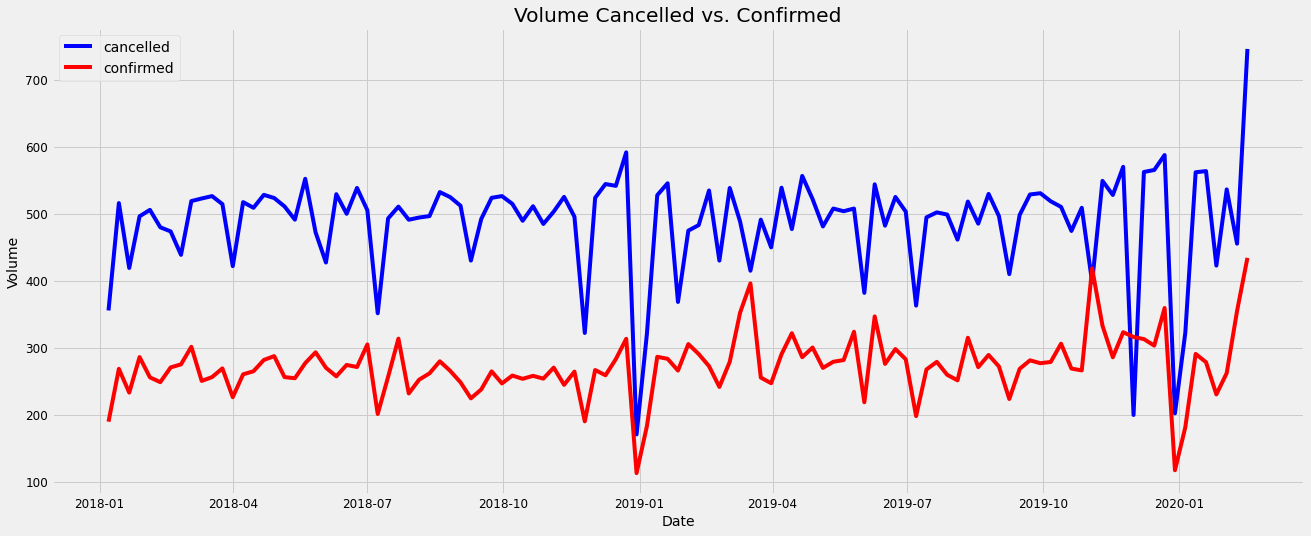

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(pre['contact_date'], pre['cancelled_vol'], 'b-', label = 'cancelled')
plt.plot(pre['contact_date'], pre['confirmed_vol'], 'r-', label = 'confirmed')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.title('Volume Cancelled vs. Confirmed')
plt.legend();

<Figure size 1296x432 with 0 Axes>

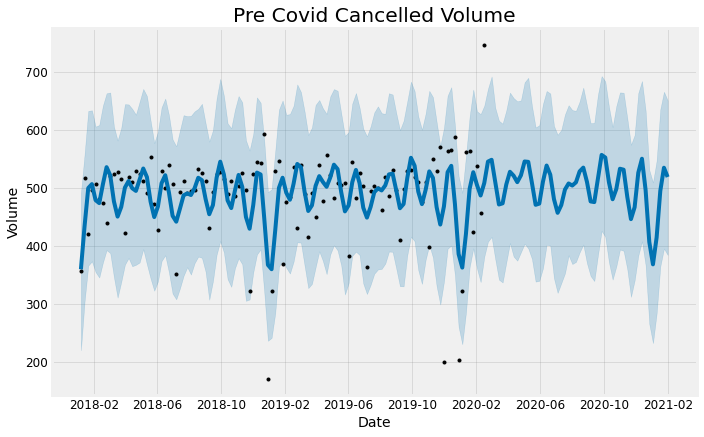

In [ ]:
from fbprophet import Prophet

precan = precan.rename(columns={'contact_date': 'ds', 'one': 'y'})
precan_model = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
precan_model.fit(precan)

precon = precon.rename(columns={'contact_date': 'ds', 'one': 'y'})
precon_model = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
precon_model.fit(precon)

precan_forecast = precan_model.make_future_dataframe(periods=50, freq='W')
precan_forecast = precan_model.predict(precan_forecast)

precon_forecast = precon_model.make_future_dataframe(periods=50, freq='W')
precon_forecast = precon_model.predict(precon_forecast)

plt.figure(figsize=(18, 6))
precan_model.plot(precan_forecast, xlabel = 'Date', ylabel = 'Volume')
plt.title('Pre Covid Cancelled Volume');

<Figure size 1296x432 with 0 Axes>

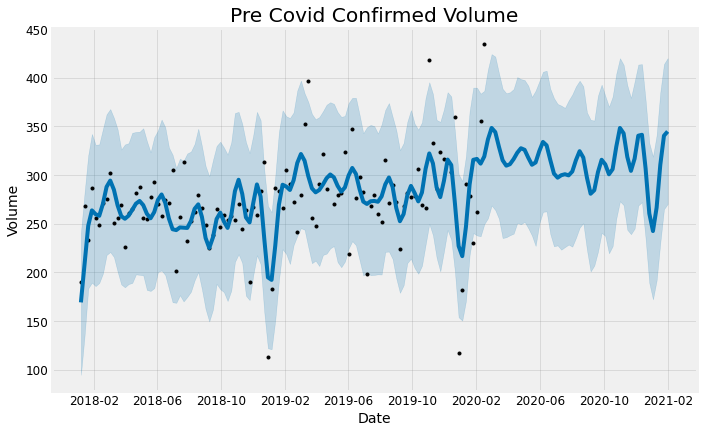

In [ ]:
plt.figure(figsize=(18, 6))
precon_model.plot(precon_forecast, xlabel = 'Date', ylabel = 'Volume')
plt.title('Pre Covid Confirmed Volume');

In [ ]:
precan_names = ['precan_%s' % column for column in precan_forecast.columns]
precon_names = ['precon_%s' % column for column in precon_forecast.columns]

merge_precan_forecast = precan_forecast.copy()
merge_precon_forecast = precon_forecast.copy()

merge_precan_forecast.columns = precan_names
merge_precon_forecast.columns = precon_names

forecast = pd.merge(merge_precan_forecast, merge_precon_forecast, how = 'inner', left_on = 'precan_ds', right_on = 'precon_ds')

forecast = forecast.rename(columns={'precan_ds': 'Date'}).drop('precon_ds', axis=1)
forecast.head()

,Date,precan_trend,precan_yhat_lower,precan_yhat_upper,precan_trend_lower,precan_trend_upper,precan_additive_terms,precan_additive_terms_lower,precan_additive_terms_upper,precan_daily,...,precon_weekly,precon_weekly_lower,precon_weekly_upper,precon_yearly,precon_yearly_lower,precon_yearly_upper,precon_multiplicative_terms,precon_multiplicative_terms_lower,precon_multiplicative_terms_upper,precon_yhat
0,2018-01-07,370.827649,219.684208,490.489200,370.827649,370.827649,-11.639584,-11.639584,-11.639584,62.420039,...,20.453632,20.453632,20.453632,-74.848093,-74.848093,-74.848093,0.0,0.0,0.0,169.243079
1,2018-01-14,370.984926,303.997398,557.185285,370.984926,370.984926,62.720759,62.720759,62.720759,62.420039,...,20.453632,20.453632,20.453632,-36.295289,-36.295289,-36.295289,0.0,0.0,0.0,208.317712
2,2018-01-21,371.142204,365.528240,632.124952,371.142204,371.142204,128.058421,128.058421,128.058421,62.420039,...,20.453632,20.453632,20.453632,2.961072,2.961072,2.961072,0.0,0.0,0.0,248.095902
3,2018-01-28,371.299482,373.004012,633.192233,371.299482,371.299482,134.691657,134.691657,134.691657,62.420039,...,20.453632,20.453632,20.453632,18.097729,18.097729,18.097729,0.0,0.0,0.0,263.754388
4,2018-02-04,371.456759,354.521144,605.165003,371.456759,371.456759,106.939370,106.939370,106.939370,62.420039,...,20.453632,20.453632,20.453632,13.672805,13.672805,13.672805,0.0,0.0,0.0,259.851293


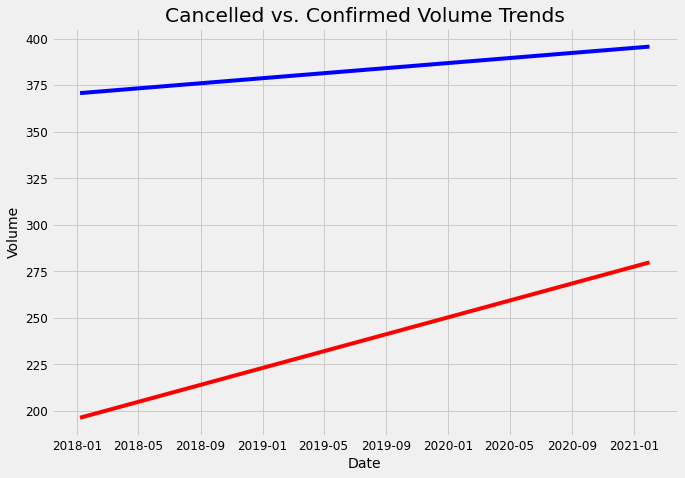

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['precan_trend'], 'b-')
plt.plot(forecast['Date'], forecast['precon_trend'], 'r-')
plt.xlabel('Date'); plt.ylabel('Volume')
plt.title('Cancelled vs. Confirmed Volume Trends');

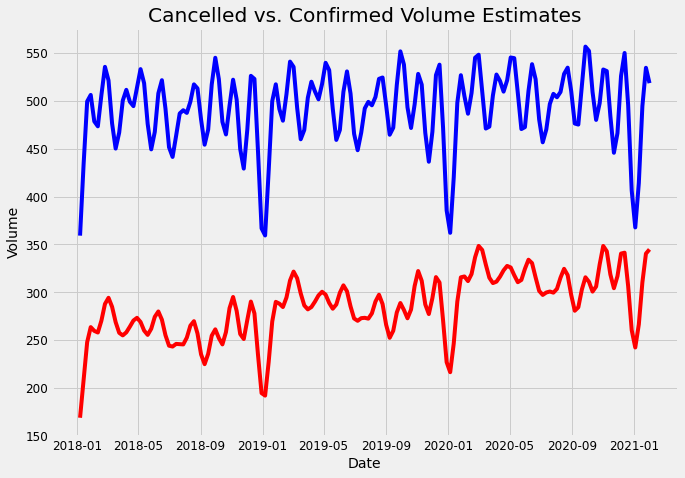

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['precan_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['precon_yhat'], 'r-')
plt.xlabel('Date'); plt.ylabel('Volume')
plt.title('Cancelled vs. Confirmed Volume Estimates');

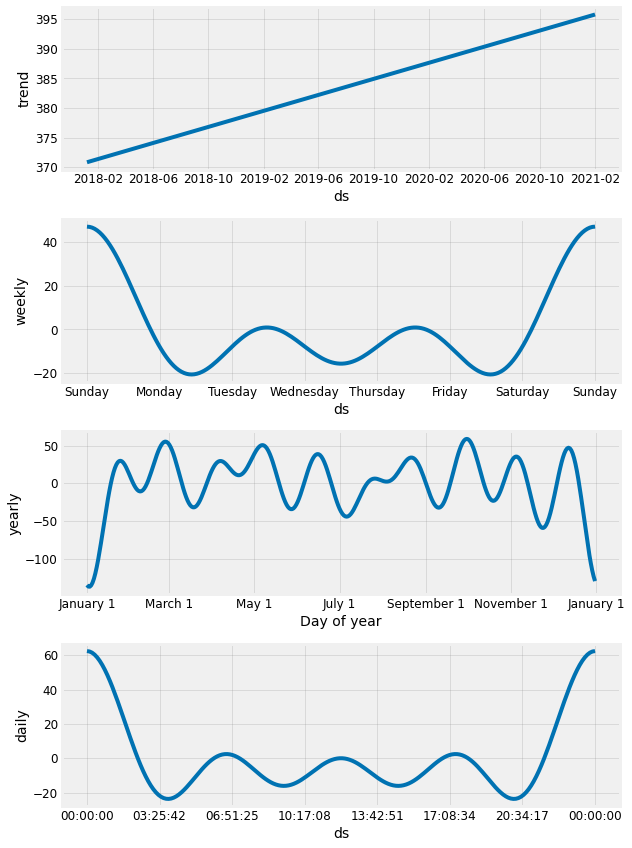

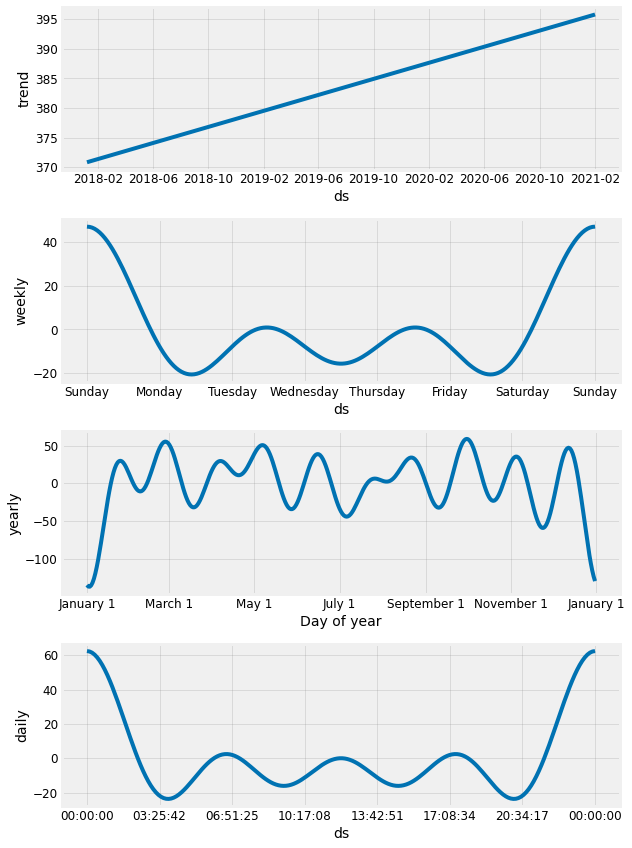

In [ ]:
precan_model.plot_components(precan_forecast)

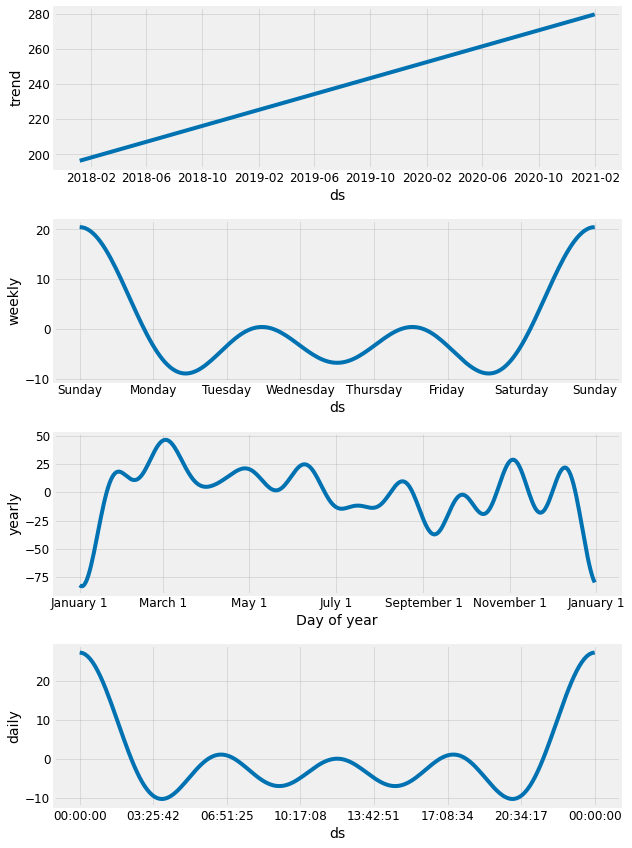

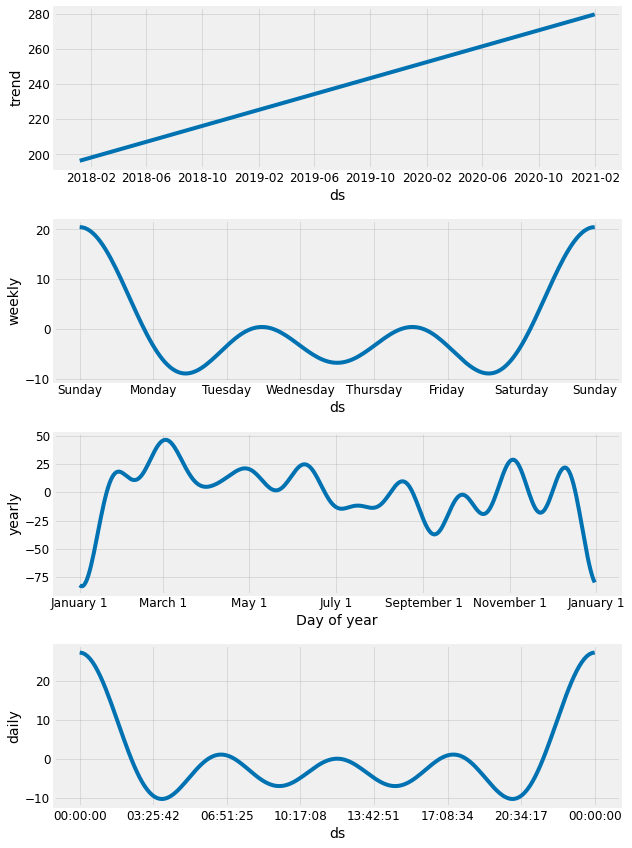

In [ ]:
precon_model.plot_components(precon_forecast)

### Covid CvC

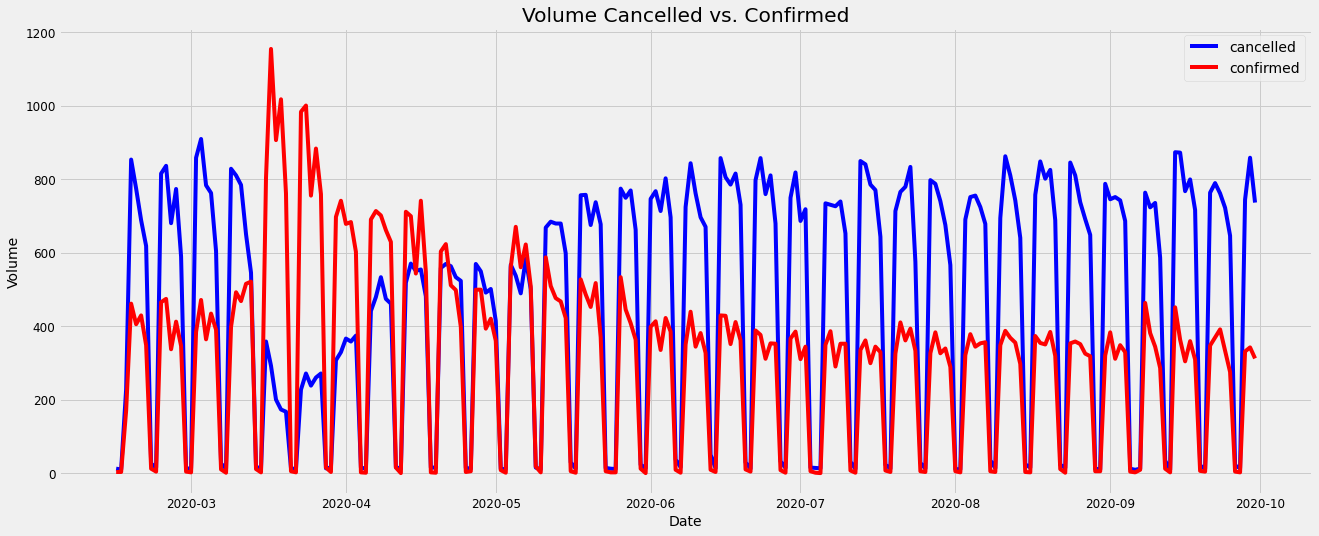

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(covid['contact_date'], covid['cancelled_vol'], 'b-', label = 'cancelled')
plt.plot(covid['contact_date'], covid['confirmed_vol'], 'r-', label = 'confirmed')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.title('Volume Cancelled vs. Confirmed')
plt.legend();

<Figure size 1296x432 with 0 Axes>

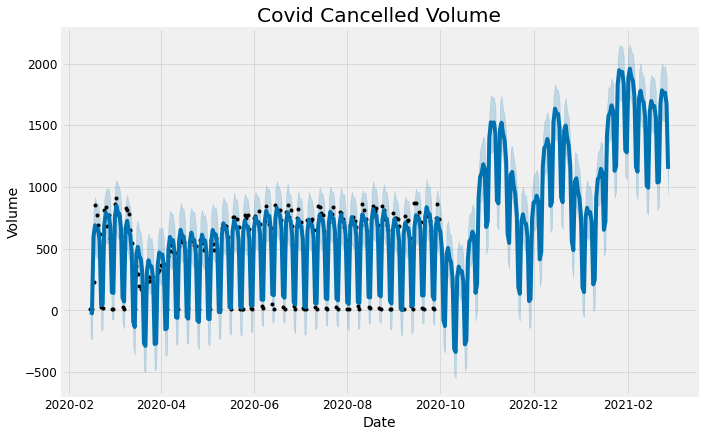

In [ ]:
covidcan = covidcan.rename(columns={'contact_date': 'ds', 'one': 'y'})
covidcan_model = Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
covidcan_model.fit(covidcan)

covidcon = covidcon.rename(columns={'contact_date': 'ds', 'one': 'y'})
covidcon_model = Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
covidcon_model.fit(covidcon)

covidcan_forecast = covidcan_model.make_future_dataframe(periods=150, freq='D')
covidcan_forecast = covidcan_model.predict(covidcan_forecast)

covidcon_forecast = covidcon_model.make_future_dataframe(periods=150, freq='D')
covidcon_forecast = covidcon_model.predict(covidcon_forecast)

plt.figure(figsize=(18, 6))
covidcan_model.plot(covidcan_forecast, xlabel = 'Date', ylabel = 'Volume')
plt.title('Covid Cancelled Volume');

<Figure size 1296x432 with 0 Axes>

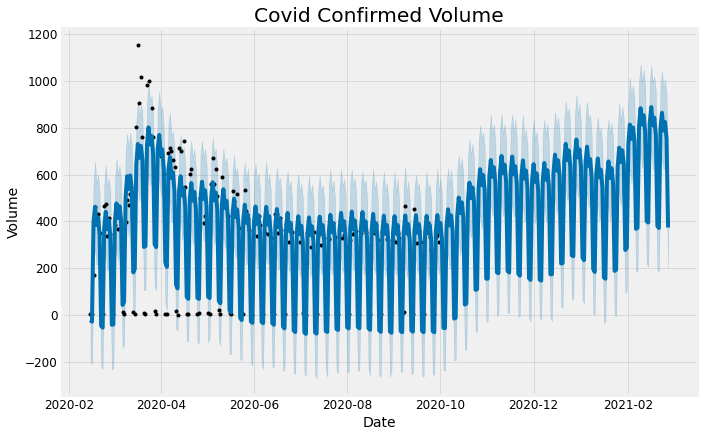

In [ ]:
plt.figure(figsize=(18, 6))
covidcon_model.plot(covidcon_forecast, xlabel = 'Date', ylabel = 'Volume')
plt.title('Covid Confirmed Volume');

In [ ]:
covidcan_names = ['covidcan_%s' % column for column in covidcan_forecast.columns]
covidcon_names = ['covidcon_%s' % column for column in covidcon_forecast.columns]

merge_covidcan_forecast = covidcan_forecast.copy()
merge_covidcon_forecast = covidcon_forecast.copy()

merge_covidcan_forecast.columns = covidcan_names
merge_covidcon_forecast.columns = covidcon_names

forecast = pd.merge(merge_covidcan_forecast, merge_covidcon_forecast, how = 'inner', left_on = 'covidcan_ds', right_on = 'covidcon_ds')

forecast = forecast.rename(columns={'covidcan_ds': 'Date'}).drop('covidcon_ds', axis=1)
forecast.head()

,Date,covidcan_trend,covidcan_yhat_lower,covidcan_yhat_upper,covidcan_trend_lower,covidcan_trend_upper,covidcan_additive_terms,covidcan_additive_terms_lower,covidcan_additive_terms_upper,covidcan_daily,...,covidcon_weekly,covidcon_weekly_lower,covidcon_weekly_upper,covidcon_yearly,covidcon_yearly_lower,covidcon_yearly_upper,covidcon_multiplicative_terms,covidcon_multiplicative_terms_lower,covidcon_multiplicative_terms_upper,covidcon_yhat
0,2020-02-15,39.772740,-219.642988,207.718481,39.772740,39.772740,-50.528498,-50.528498,-50.528498,107.202685,...,-309.871512,-309.871512,-309.871512,117.086573,117.086573,117.086573,0.0,0.0,0.0,-22.585378
1,2020-02-16,42.545226,-234.965414,197.371634,42.545226,42.545226,-65.464662,-65.464662,-65.464662,107.202685,...,-314.895816,-314.895816,-314.895816,113.845488,113.845488,113.845488,0.0,0.0,0.0,-29.695646
2,2020-02-17,45.317712,371.386089,809.449460,45.317712,45.317712,551.917458,551.917458,551.917458,107.202685,...,113.426308,113.426308,113.426308,109.774039,109.774039,109.774039,0.0,0.0,0.0,395.710150
3,2020-02-18,48.090198,469.624551,917.529969,48.090198,48.090198,641.860522,641.860522,641.860522,107.202685,...,183.441383,183.441383,183.441383,105.083457,105.083457,105.083457,0.0,0.0,0.0,462.189763
4,2020-02-19,50.862685,425.515090,865.736675,50.862685,50.862685,599.487071,599.487071,599.487071,107.202685,...,108.741853,108.741853,108.741853,100.003807,100.003807,100.003807,0.0,0.0,0.0,383.565705


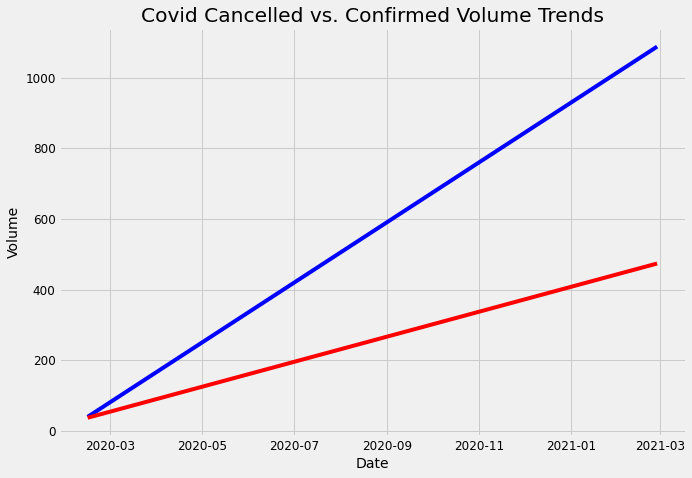

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['covidcan_trend'], 'b-')
plt.plot(forecast['Date'], forecast['covidcon_trend'], 'r-')
plt.xlabel('Date'); plt.ylabel('Volume')
plt.title('Covid Cancelled vs. Confirmed Volume Trends');

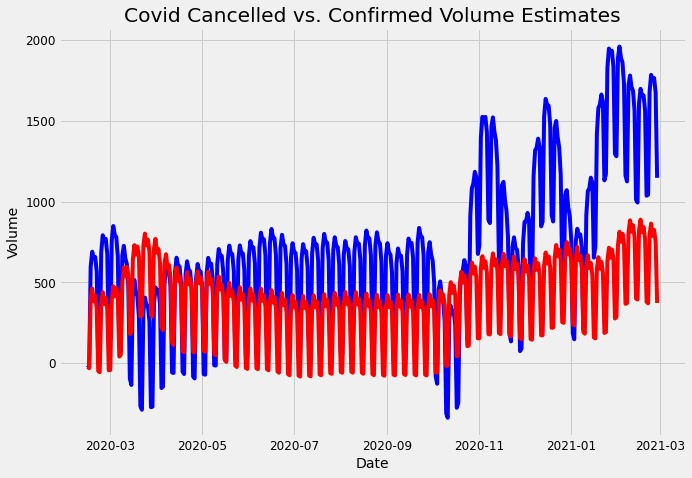

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['covidcan_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['covidcon_yhat'], 'r-')
plt.xlabel('Date'); plt.ylabel('Volume')
plt.title('Covid Cancelled vs. Confirmed Volume Estimates');

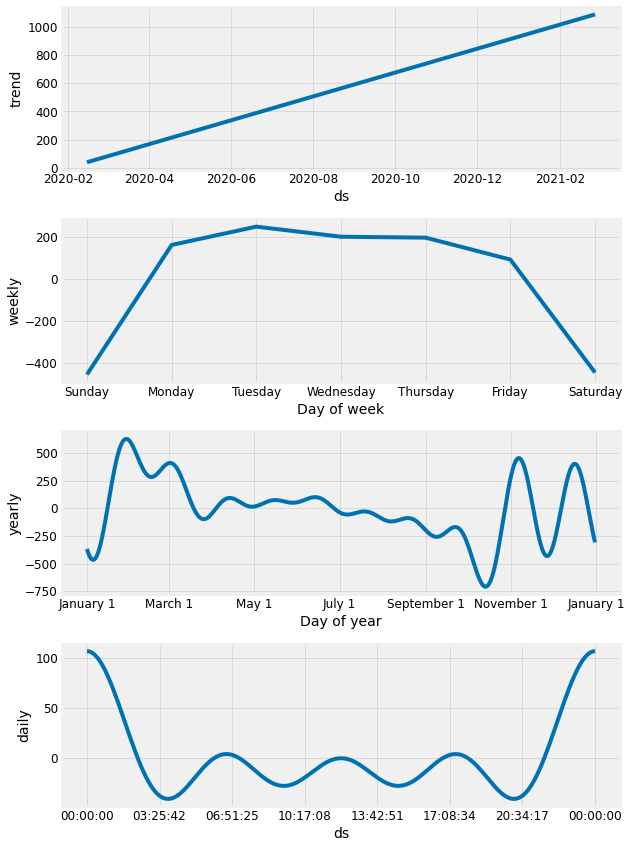

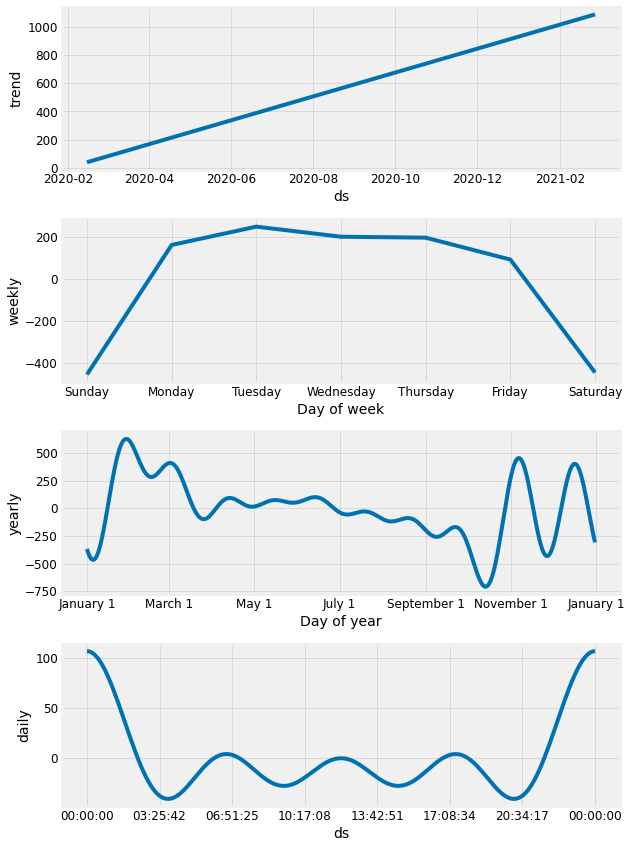

In [ ]:
covidcan_model.plot_components(covidcan_forecast)

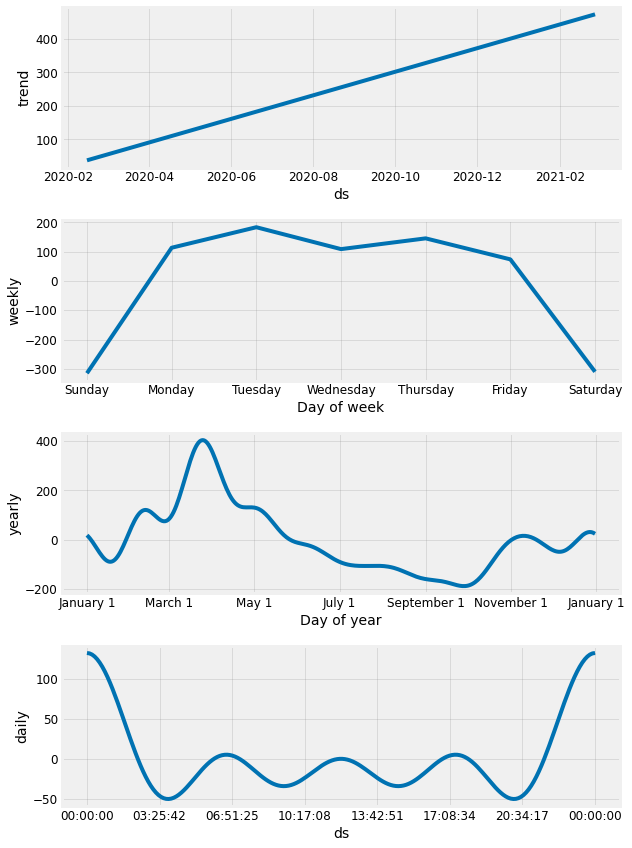

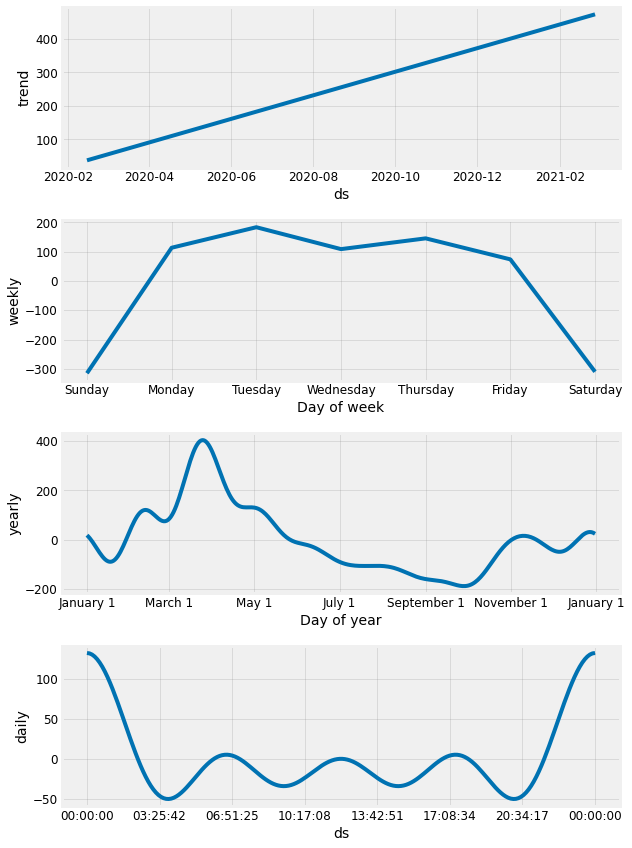

In [ ]:
covidcon_model.plot_components(covidcon_forecast)